## Errors and Optimization

Copyright (C) 2024, B. Zeller-Plumhoff

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html) for more details.

This Jupyter Notebook was created by Berit Zeller-Plumhoff. 

Within the notebook, you will fit polynomials of increasing degree to different data sets to study the effect of overfitting. You will then make use of the division of your data into training and testing data, so as to determine which polynomial degree produces the best results without overfitting.

We begin by loading the required libraries.

In [1]:
import pandas as pd # library for organizing data
import numpy as np # library for numerial computations
from sklearn import linear_model # the linear_model library establishes a straightforward implementation of a linear regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # these libraries enable the calculation of the MSE, MAE and R2 goodness of fit
from sklearn.preprocessing import PolynomialFeatures # this library allows you to automatically produce polynomial features of varying degree
from sklearn.model_selection import train_test_split # this library enables the splitting of a data set into training and test data
from scipy.optimize import minimize

import matplotlib.pyplot as plt # library for plotting (not interactive)

We will first define a data set that we will use for polynomial regression. This example is taken from the course [Introduction to Machine Learning](https://slds-lmu.github.io), available under a [CC BY 4.0 license](https://creativecommons.org/licenses/by/4.0/).

Define an array $x \in [0,1]$ with $\Delta x=0.05$. The function we aim to fit will be $$y=0.5+0.4\cdot\sin(2\pi x)+\frac{\epsilon-0.5}{5}$$ where $\epsilon\in[0,1)$ is a noise term that you should generate _randomly_. 

In [2]:
x=np.arange(0,1.05,0.05)
noise=(np.random.rand(np.size(x))-0.5)/5
y=0.5+0.4*np.sin(2*np.pi*x)+noise

Plot the data you have created, including axes labels.

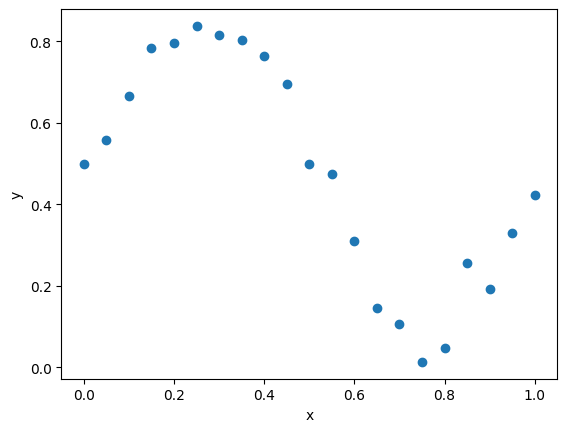

In [3]:
plt.scatter(x=x,y=y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In the following, we wish to find a set of polynomial functions up to polynomial degree $d$ that will be able to fit the sine function well. Importantly, we will see how large $d$ can lead to overfitting, while low $d$ underfit the data.

Firstly, define a function that will train a linear regression model based on inputs X_train and Y_train and that returns both the model and the predicted labels for the training data.

In [4]:
def regression(X_train, Y_train):
    
    # Define the model using linear_model and LinearRegression from Scikit_learn
    model = linear_model.LinearRegression()
    # train the model using .fit
    model.fit(X_train, Y_train)
        
    # Use the model to predict the entire set of data using .predict
    predictions = model.predict(X_train) 
    
    # return the predictions and the fitted model
    return predictions, model

We wish to trial different polynomial degrees for performing the polynomial regression with the data we have just created. Use the _PolynomialFeatures_ function to create training features with a maximum degree of $d\in\{1,3,9,11,15\}$.

In [5]:
poly3 = PolynomialFeatures(degree=3, include_bias=False)
x_train3 = poly3.fit_transform(x.reshape(-1, 1))
poly9 = PolynomialFeatures(degree=9, include_bias=False)
x_train9 = poly9.fit_transform(x.reshape(-1, 1))
poly11 = PolynomialFeatures(degree=11, include_bias=False)
x_train11 = poly11.fit_transform(x.reshape(-1, 1))
poly15 = PolynomialFeatures(degree=15, include_bias=False)
x_train15 = poly15.fit_transform(x.reshape(-1, 1))

Perform the training of the linear regression model with the different features you have created.

In [6]:
predictions, model = regression(x.reshape(-1, 1), y.reshape(-1, 1)) # This line calls the Regression model implemented in the function 
predictions3, model3 = regression(x_train3, y.reshape(-1, 1)) 
predictions9, model9 = regression(x_train9, y.reshape(-1, 1)) 
predictions11, model11 = regression(x_train11, y.reshape(-1, 1)) 
predictions15, model15 = regression(x_train15, y.reshape(-1, 1)) 

Plot the original data and the fitted models into one plot. Make sure to use a sufficiently fine $\Delta x$ for plotting the functions continuously and include a legend in your figure for differentiation of the different functions.

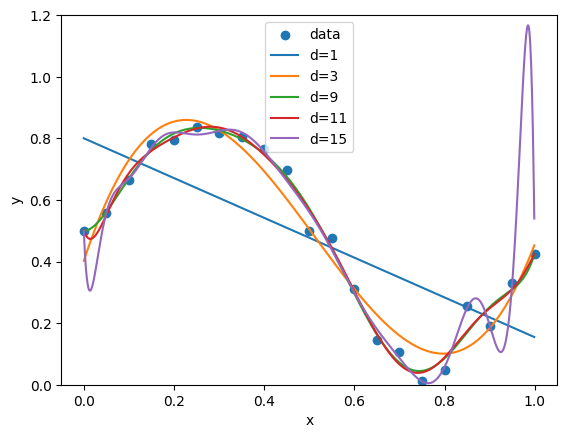

In [7]:
# define an array for plotting that is refined in x - create its polynomial features
x_plt=np.arange(0,1,0.001)
x_plt3=poly3.fit_transform(x_plt.reshape(-1, 1))
x_plt9=poly9.fit_transform(x_plt.reshape(-1, 1))
x_plt11=poly11.fit_transform(x_plt.reshape(-1, 1))
x_plt15=poly15.fit_transform(x_plt.reshape(-1, 1))
# calculate the different model predictions
y_plt=model.predict(x_plt.reshape(-1, 1))
y_plt3=model3.predict(x_plt3)
y_plt9=model9.predict(x_plt9)
y_plt11=model11.predict(x_plt11)
y_plt15=model15.predict(x_plt15)

# plot your data using a scatter plot for the original data and lines for the fitted functions
# include a legend and axes labels and make sure that the data is well visible.
plt.scatter(x=x,y=y, label='data')
plt.plot(x_plt,y_plt,label='d=1')
plt.plot(x_plt,y_plt3,label='d=3')
plt.plot(x_plt,y_plt9,label='d=9')
plt.plot(x_plt,y_plt11,label='d=11')
plt.plot(x_plt,y_plt15,label='d=15')
plt.ylim([0,1.2])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

What can you conclude based on looking at the figure? Can you explain why the best fit is a good approximation mathematically?

### Train and testing split

In this section of the notebook, we will fit a different set of data and determine the ideal polynomial degree by making use of testing and training data.

Specifically, we want to determine $d$ that best describes the relationship $\sigma_{pe} \propto \frac{1}{E^d}$, where $E$ is the X-ray energy and $\sigma_{pe}$ the photo-electric cross-section, which is a measure of likelihood that the photo-eletric effect will occur.

First, read in the file _xray2845.dat.txt_ that was extract from the [Henke database](https://henke.lbl.gov/optical_constants/)<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). The file contains the real $\delta$ and imaginary $\beta$ increments of the refractive index $n=1-\delta+i\beta$ of titanium for X-rays of energies ranging from 5 to 30 keV. When using pandas to read in the data, make sure to only use columns 2,4,6 and remove the two header lines. Column names should be 'Energy / eV', 'delta','beta'.

In [8]:
data_xray=pd.read_csv('../data/xray2845.dat.txt', sep=' ', header=2, usecols=[2,4,6], names=['Energy / eV', 'delta','beta'])

While our data readily contains $E$, we need to determine $\sigma_{pe}$ or an approximation thereof. The photo-electric effect is one of several X-ray interactions with matter and the most prominent at low X-ray energies. Therefore, we can assume for the total cross-section that describes the likelihood of any interaction, $\sigma_{tot}\approx\sigma_{pe}$. This likelihood is related to the X-ray attenuation coefficient $\mu\propto\sigma_{tot}\approx\sigma_{pe}$ and at the same time $\mu=\frac{4\pi}{\lambda}\beta$, where the wavelength $\lambda=\frac{hc}{E}$ with $h$ Planck's constant and $c$ the speed of light. Therefore, to determine $d$, first compute $\mu$. 

In [9]:
E=data_xray["Energy / eV"]
beta=data_xray["beta"]
h=4.136*10**(-15) #eV*s
c=2.998*10**(8) #m/s
lbda=h*c/(E) # m
mu=4*np.pi/lbda*beta

Plot $\mu$ vs. $E$ applying log-log scaling to the axes. You should obtain a linear function. Include axes labels.

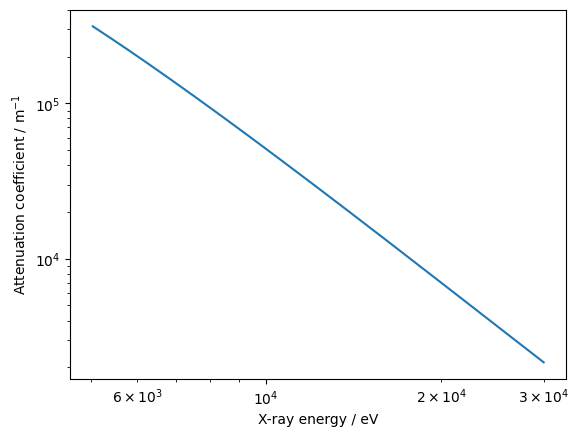

In [10]:
plt.plot(E,mu)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('X-ray energy / eV')
plt.ylabel('Attenuation coefficient / m$^{-1}$')
plt.show()

We now wish to trial which polynomial $d$ best describes this relationship for $d\in[1,15]$. You should assess both MAE and MSE for the training and testing data. Use _train_test_split_ to split your data into 2/3 training and 1/3 testing data. Write a for loop that will test all polynomial degrees (making sure that only one degree is considered at any one time) and plot the training and testing MSE and MAE in one overall figure at the end. What conclusion can you draw? Double check on the internet, what is the relationship between $\sigma_{pe}$ and $E$?

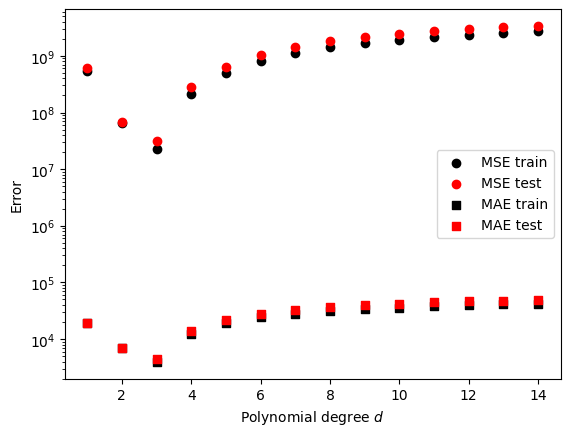

In [11]:
# set your maximum degree size and initialize your mse and mae variables
max_deg=15
mse_train=np.empty(max_deg)
mae_train=np.empty(max_deg)
mse_test=np.empty(max_deg)
mae_test=np.empty(max_deg)

# split your data sets
X_train, X_test, y_train, y_test = train_test_split(np.array(1/E).reshape(-1, 1),np.array(mu).reshape(-1, 1), test_size=0.33)#, random_state=42

# define your for loop
for i in range(1,max_deg):
    # create polynomial features
    poly = PolynomialFeatures(degree=(i,i), include_bias=False)
    E_train = poly.fit_transform(X_train)
    E_test = poly.fit_transform(X_test)

    # perform regression and prediction for training and testing data
    pred_train, model3 = regression(E_train, y_train)
    pred_test=model3.predict(E_test)
    
    # determine the different error metrics
    mse_train[i] = mean_squared_error(y_train, pred_train)
    mae_train[i] = mean_absolute_error(y_train, pred_train)
    mse_test[i] = mean_squared_error(y_test, pred_test)
    mae_test[i] = mean_absolute_error(y_test, pred_test)

# plot your results, make sure they are readable, and include a axes labels and a legend 
plt.scatter(x=np.arange(1,max_deg),y=mse_train[1:max_deg],color='black',label='MSE train')
plt.scatter(x=np.arange(1,max_deg),y=mse_test[1:max_deg],color='red',label='MSE test')
plt.scatter(x=np.arange(1,max_deg),y=mae_train[1:max_deg],marker='s',color='black',label='MAE train')
plt.scatter(x=np.arange(1,max_deg),y=mae_test[1:max_deg],marker='s',color='red',label='MAE test')
plt.xlabel('Polynomial degree $d$')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()

Now trial how setting the size of training vs. testing data set has influenced your results by changing that parameter.

<a name="cite_note-1"></a>1.[^](#cite_ref-1) B.L. Henke, E.M. Gullikson, and J.C. Davis. X-ray interactions: photoabsorption, scattering, transmission, and reflection at E=50-30000 eV, Z=1-92, Atomic Data and Nuclear Data Tables Vol. 54 (no.2), 181-342 (July 1993)

### Practical - Hall-Petch-relationship

In this section, you will compare the results from fitting a linear regrssion using either the L$_1$ loss or L$_2$ loss. The data set you will use are the grain size and yield stress of a MnFeNi alloy attained at different temperatures. The data is taken from [Schneider et al., Data in Brief (2020), 28](https://doi.org/10.1016/j.dib.2019.104807)<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2), available under a [CC BY 4.0 license](https://creativecommons.org/licenses/by/4.0/), and saved in sheet 2 of the file _GS_T_YS.xlsx_.

To begin, read in the data and display it.

In [12]:
data_gs=pd.read_excel('../data/GS_T_YS.xlsx', sheet_name=1)
data_gs

,d (µm),c (µm),YS (Mpa) - 77K,YS (Mpa) - 293K,YS (Mpa) - 673K,YS (Mpa) - 873K
0,17,13,388,263,184,192
1,19,16,384,252,173,179
2,22,14,360,239,177,175
3,33,25,341,206,128,148
4,66,49,315,175,91,111
5,112,86,278,155,103,95
6,216,120,283,146,88,96


Plot the yield stress against the grain size for each of the temperatures at which the experiment was conducted - as stated in the column name of the data. Use the plotting functionality of pandas dataframes (pd.dataframe.plot).

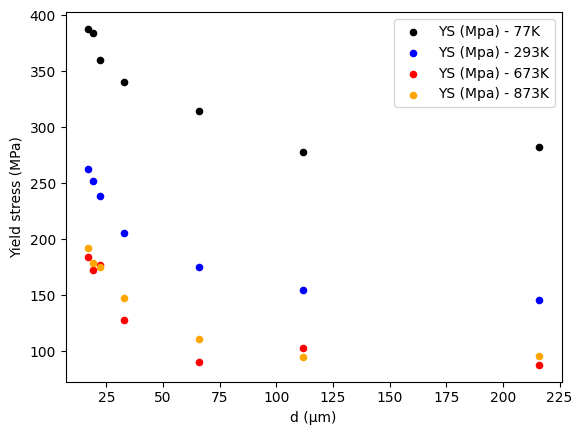

In [13]:
# plot the grain size and yield stress at the four given temperatures
# into one plot - make sure to include axes labels and a legend
fig, ax = plt.subplots()
color=['black','blue','red','orange']
column = ['YS (Mpa) - 77K','YS (Mpa) - 293K','YS (Mpa) - 673K','YS (Mpa) - 873K']
for i in range(0,4):
    data_gs.plot(x='d (µm)',y= column[i], kind='scatter', ax=ax, label=column[i], color=color[i])
plt.xlabel('d (µm)')
plt.ylabel('Yield stress (MPa)')
plt.legend()
plt.show()

The relationship between grain size $d$ and yield stress $\sigma_{0.2\%}$ can be described by the Hall-Petch relationship $$\sigma_{0.2\%}=\sigma_{0}+\frac{k_y}{\sqrt{d}}$$
where $\sigma_{0}$ is the intrinsic lattice strength of the material and $k_y$ is the strengthening coefficient.

Perform the regression analysis based on the _scikit_learn_ linear regression implementation for all four temperature and print the Hall-Petch relationship for all temperatures.

In [24]:
# assign a variable for training
d_train=1/np.sqrt(np.array(data_gs['d (µm)'])).reshape(-1,1)
models_ys=[]
# fit the four regression models for each temperature and print the
# Hall-Petch formula
for column in ['YS (Mpa) - 77K','YS (Mpa) - 293K','YS (Mpa) - 673K','YS (Mpa) - 873K']:
    ys=np.array(data_gs[column]).reshape(-1,1)
    pred,mod=regression(d_train, ys)
    models_ys.append(mod)
    print("Hall-Petch relationship for",column, ": %d / sqrt(d) + %d"%(mod.coef_, mod.intercept_))

Hall-Petch relationship for YS (Mpa) - 77K : 642 / sqrt(d) + 230
Hall-Petch relationship for YS (Mpa) - 293K : 686 / sqrt(d) + 92
Hall-Petch relationship for YS (Mpa) - 673K : 587 / sqrt(d) + 38
Hall-Petch relationship for YS (Mpa) - 873K : 592 / sqrt(d) + 45


C:\Users\berit\AppData\Local\Temp\ipykernel_21276\1964417322.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Hall-Petch relationship for",column, ": %d / sqrt(d) + %d"%(mod.coef_, mod.intercept_))
C:\Users\berit\AppData\Local\Temp\ipykernel_21276\1964417322.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Hall-Petch relationship for",column, ": %d / sqrt(d) + %d"%(mod.coef_, mod.intercept_))
C:\Users\berit\AppData\Local\Temp\ipykernel_21276\1964417322.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your arra

Compare the values you have calculated to those published in Table 2 of [Schneider et al., mdpi Metals (2019), 9(1)](https://www.mdpi.com/2075-4701/9/1/84).

### L$_1$ loss

As the linear regression model in _scikit_learn_ is based on the L$_2$ norm, we would like to compare how the L$_1$ norm would compare. To fit a regression model using the L$_1$ norm, you need to implement it as a minimization problem in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

Firstly, define two functions. One that applies a linear fit with two parameters, namely the intercept $\theta_0$ and the slope $\theta_1$ of the linear model $\hat{y}=\theta_1x+\theta_0$. This function should take as input the values $x$ and the two parameters. The second function should take the same inputs in addition to the observed values $y$. This function should output the L$_1$ error $$\sum_{i=1}^p |(y^{(p)}-\hat{y}^{(p)})|$$
where $p$ is the number of data points available for the fitting.

In [15]:
# define a function that computes and returns y_hat
def fit(x, params):
    return x*params[1]+params[0]

# define a function that computes and returns the L1 loss based on y_hat 
# and the original y values
def cost_function(params, x, y):
    return np.sum(np.abs(y - fit(x, params)))

Based on the functions that you have now defined, use _scipy.minimize_ to calculate the optimal model parameters $\theta_0$ and $\theta_1$. Perform this calculation for all temperatures and print the resulting Hall-Petch relationship.

In [16]:
i=0
par_opt=[]
# fit the four regression models for each temperature and print the
# Hall-Petch formula
for column in ['YS (Mpa) - 77K','YS (Mpa) - 293K','YS (Mpa) - 673K','YS (Mpa) - 873K']:
    par0=np.array([models_ys[i].intercept_[0],models_ys[i].coef_[0][0]])
    ys=np.array(data_gs[column]).reshape(-1,1)
    output = minimize(cost_function, par0, args=(d_train, ys))
    par_opt.append(output.x)
    i=i+1
    print("Hall-Petch relationship for",column, ": %d / sqrt(d) + %d"%(output.x[1], output.x[0]))

Hall-Petch relationship for YS (Mpa) - 77K : 642 / sqrt(d) + 232
Hall-Petch relationship for YS (Mpa) - 293K : 686 / sqrt(d) + 92
Hall-Petch relationship for YS (Mpa) - 673K : 588 / sqrt(d) + 41
Hall-Petch relationship for YS (Mpa) - 873K : 592 / sqrt(d) + 44


How do the fitted models for the L$_1$ norm and the L$_2$ norm compare? Plot the data and both fitted models for each data set into one graph. Explain why L$_1$ norm and L$_2$ norm result in larger or smaller differences based on each data set.

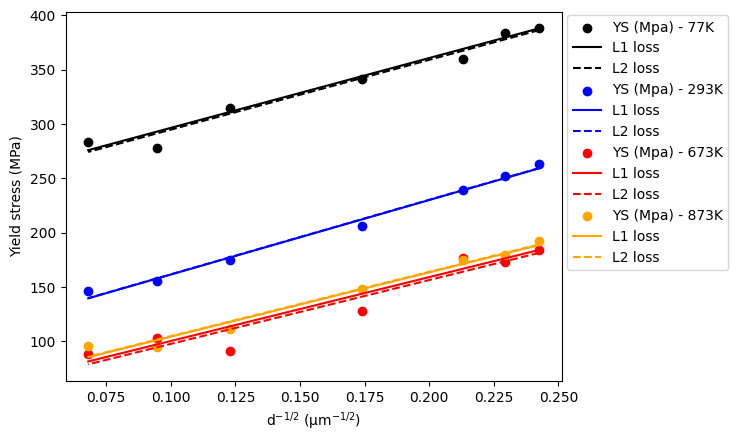

In [17]:
# plot the reciprocal of the square root of the grain size and 
# yield stress at the four given temperatures into one plot 
# make sure to include axes labels and a legend
fig, axs = plt.subplots()
column = ['YS (Mpa) - 77K','YS (Mpa) - 293K','YS (Mpa) - 673K','YS (Mpa) - 873K']
for i in range(0,4):
    plt.scatter(x=d_train,y=data_gs[column[i]], label=column[i], color=color[i])
    plt.plot(d_train,fit(d_train,par_opt[i]),
                label='L1 loss', color=color[i])
    plt.plot(d_train,models_ys[i].predict(d_train),
                label='L2 loss', linestyle='dashed',color=color[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.01))
plt.xlabel('d$^{-1/2}$ (µm$^{-1/2}$)')
plt.ylabel('Yield stress (MPa)')
plt.show()

Finally, to compare your fitted values against those in the original publication more clearly, generate four graphs in which you plot one data set each, as well as our fitted values and the fits given in the publication. Make use of _pyplot.subplots_ to do so.

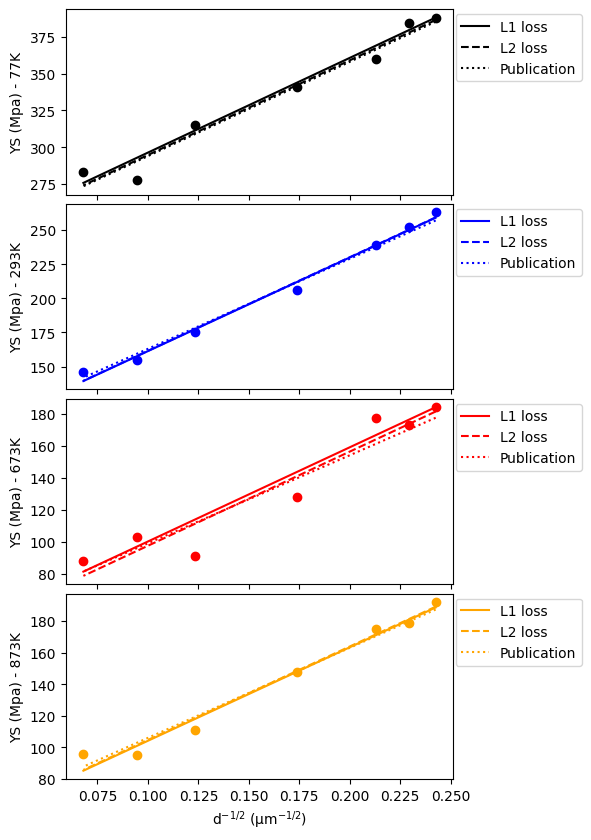

In [18]:
fig, axs = plt.subplots(4, sharex=True,figsize=(5,10))
plt.subplots_adjust(hspace=0.05)
par_pub=[[230,640],[97,660],[44,550],[49,570]]
for i in range(0,4):
    axs[i].scatter(x=d_train,y= data_gs[column[i]],
                color=color[i])
    axs[i].plot(d_train,fit(d_train,par_opt[i]),
                label='L1 loss', color=color[i])
    axs[i].plot(d_train,models_ys[i].predict(d_train),
                label='L2 loss', linestyle='dashed',color=color[i])
    axs[i].plot(d_train,fit(d_train,par_pub[i]),
                label='Publication', linestyle='dotted',color=color[i])
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.35, 1.01))
    axs[i].set_ylabel(column[i])
plt.xlabel('d$^{-1/2}$ (µm$^{-1/2}$)')
plt.show()

Calculate and plot the goodness of the fit for each of the three models and all four cases.

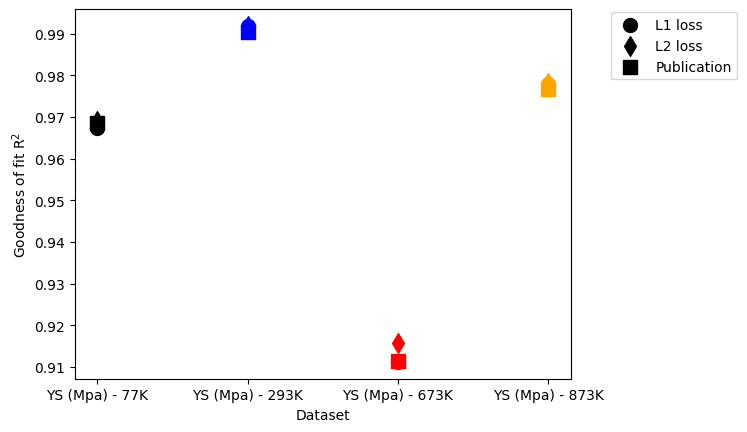

In [19]:
for i in range(0,4):
    plt.scatter(x=column[i],y= r2_score(data_gs[column[i]],fit(d_train,par_opt[i])), s=100,
                label='L1 loss', color=color[i])
    plt.scatter(x=column[i],y= r2_score(data_gs[column[i]],models_ys[i].predict(d_train)), s=100,
                label='L2 loss', marker='d',color=color[i])
    plt.scatter(x=column[i],y= r2_score(data_gs[column[i]],fit(d_train,par_pub[i])), s=100,
                label='Publication', marker='s',color=color[i])
plt.legend(['L1 loss','L2 loss','Publication'],loc='upper right', bbox_to_anchor=(1.35, 1.01))
plt.xlabel('Dataset')
plt.ylabel('Goodness of fit R$^2$')
plt.show()

<a name="cite_note-2"></a>2.[^](#cite_ref-2) Schneider, Mike; Werner, Felicitas; Langenkämper, Dennis; Reinhart, Christian; Laplanche, Guillaume (2021), “Data compilation on the effect of grain size, temperature, and texture on the strength of a single-phase FCC MnFeNi medium-entropy alloy”, Mendeley Data, V1, doi: 10.17632/828547c7df.1